In [286]:
import numpy as np
import pylab as plt
from scipy.io.wavfile import read
from scipy import signal
from sounddevice import play

plt.rcParams['axes.grid'] = True
slc = slice(4*fs, 8*fs)
fs = 44100
instruments = ['drum', 'bass', 'vocal', 'guitar']
gain = {'drum': 1, 'bass': 1.5, 'vocal': 1.5, 'guitar': 3}

C:\Software\miniconda\envs\nfb5\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
C:\Software\miniconda\envs\nfb5\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


array([-0.00130382, -0.00082681, -0.00044521, ..., -0.0058831 ,
       -0.00674172, -0.00372066])

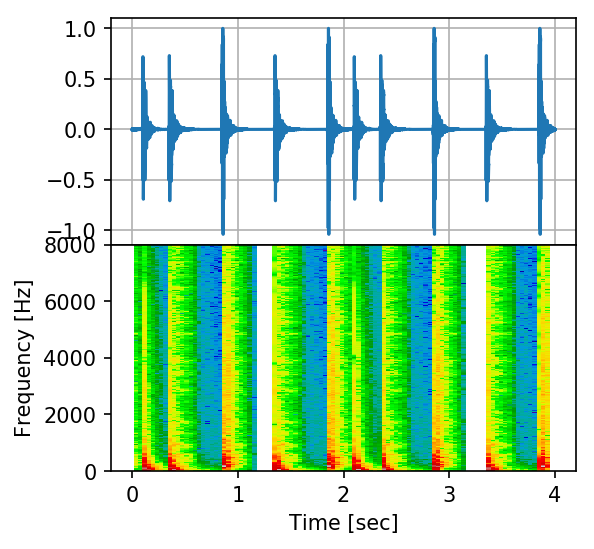

In [339]:
def show_sound(x):
    fig, ax = plt.subplots(2, figsize=(4,4), dpi=150, sharex=True)
    plt.subplots_adjust(hspace=0)
    ax[0].plot(np.arange(len(x))/fs, x)

    f, t, Sxx = signal.spectrogram(x, fs, nperseg=2000)
    ax[1].pcolormesh(t, f, np.log(Sxx), cmap='nipy_spectral')
    ax[1].set_ylabel('Frequency [Hz]')
    ax[1].set_xlabel('Time [sec]')
    ax[1].set_ylim([0, 8000])
    play(x)

def load_source(name, slc=slc, show=False):
    fs, x = read('{}.wav'.format(name))
    x = x[slc, 0]/np.max(x[:, 0])
    x = x / gain[name]
    if show:
        show_sound(x)
    return x
    
load_source('drum', show=True)

In [288]:
sources = np.vstack([load_source(inst) for inst in instruments]).T
sources

C:\Software\miniconda\envs\nfb5\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


array([[-0.00130382,  0.        ,  0.        ,  0.01876888],
       [-0.00082681,  0.        ,  0.        ,  0.02311268],
       [-0.00044521,  0.        ,  0.        ,  0.02689698],
       ...,
       [-0.0058831 ,  0.        , -0.00128237, -0.03240048],
       [-0.00674172,  0.        , -0.00128237, -0.02232938],
       [-0.00372066,  0.        , -0.00125508, -0.01466923]])

In [289]:
center_spatial_filter = np.ones(4)/4
center_spatial_filter

array([0.25, 0.25, 0.25, 0.25])

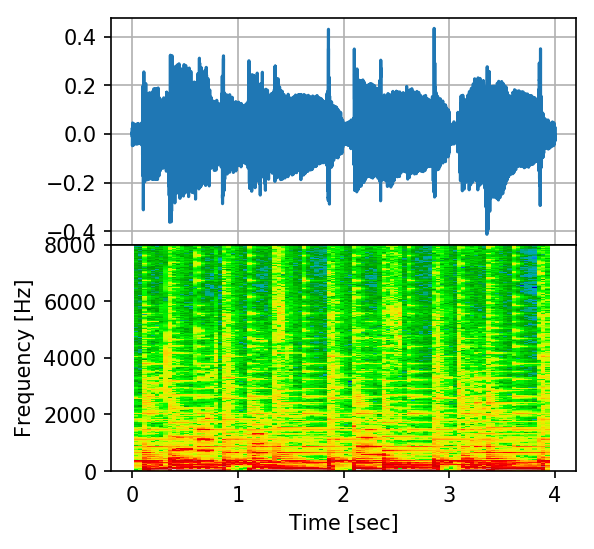

In [290]:
center_micro = sources.dot(center_spatial_filter)
show_sound(center_micro)

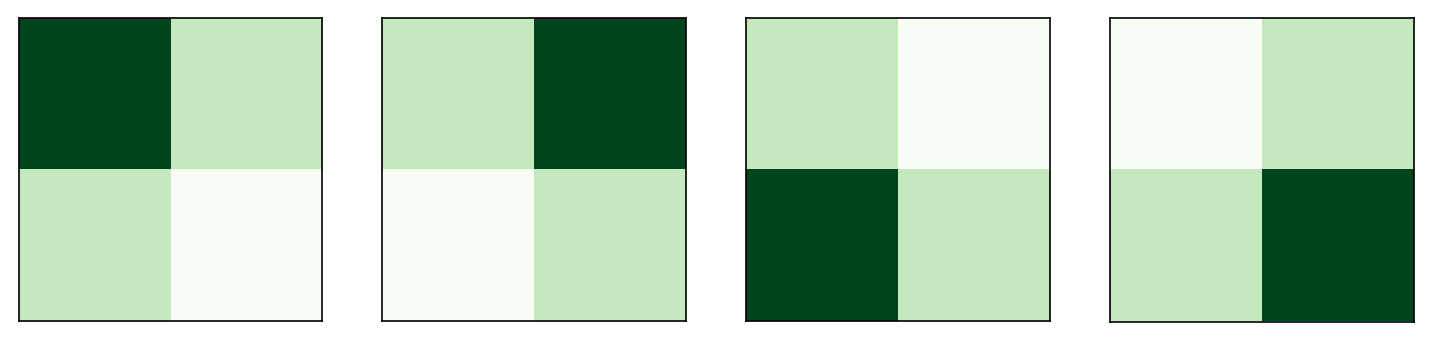

In [388]:
mixing = np.array([
    [0.5, 0.2, 0.2, 0.1],
    [0.2, 0.5, 0.1, 0.2],
    [0.2, 0.1, 0.5, 0.2],
    [0.1, 0.2, 0.2, 0.5]
])

def plot_top(filt):
    fig, ax = plt.subplots(1, 4, figsize=(12, 3), dpi=150, sharex=True)
    for s in range(4):
        ax[s].imshow(filt[:, s].reshape(2,2), cmap='Greens')
        ax[s].set_xticks([])
        ax[s].set_yticks([])
    
plot_top(mixing)

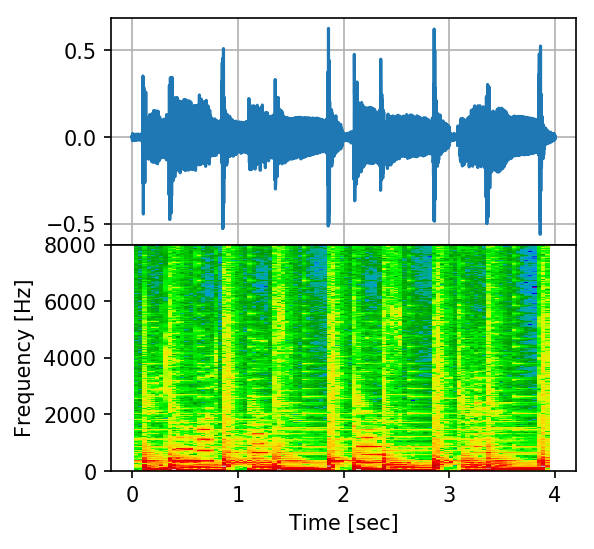

In [389]:
micro = 0
show_sound(sources.dot(mixing[:, micro]))

In [390]:
from sklearn.decomposition import FastICA, PCA
decomposition = FastICA()
decomposition.fit(x)

FastICA(algorithm='parallel', fun='logcosh', fun_args=None, max_iter=200,
    n_components=None, random_state=None, tol=0.0001, w_init=None,
    whiten=True)

In [391]:
restored_sources = decomposition.transform(x)

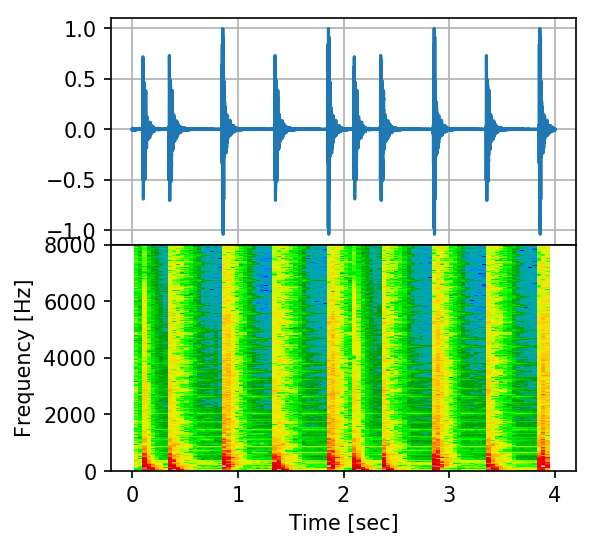

In [392]:
source = 0
show_sound(restored_sources[:, source]/np.max(restored_sources[:,source]))

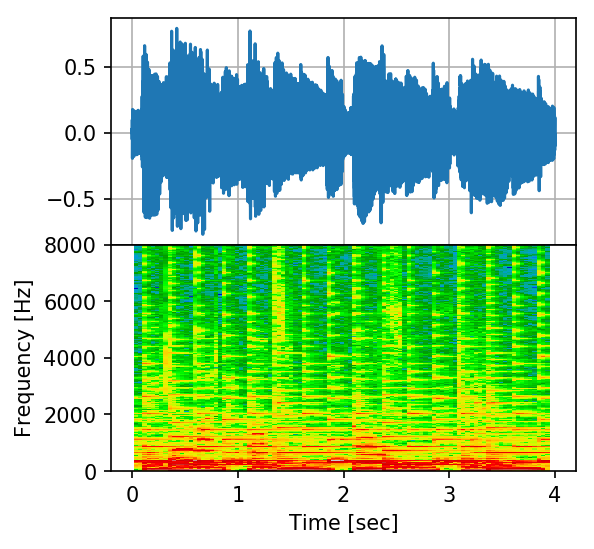

In [393]:
minus = np.sum([restored_sources[:, s]/np.max(restored_sources[:,s]) for s in range(4) if s!=source], 0)/3
show_sound(minus)

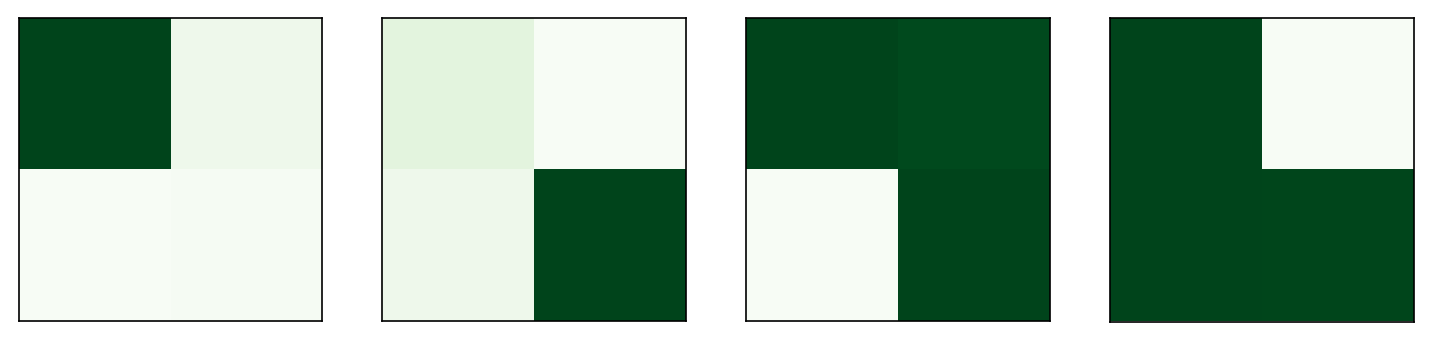

In [394]:
plot_top(decomposition.mixing_)

In [395]:
decomposition.mixing_

array([[ 4.82514950e+01,  2.75636522e-01,  9.86081910e-02,
         1.56884109e-01],
       [ 2.68213828e+00, -4.64466968e+00, -9.11713076e-01,
        -1.91387903e+02],
       [-1.71460925e-01, -2.39076002e+00, -7.07546302e+01,
        -2.42799764e-01],
       [ 5.24594042e-01,  3.26215755e+01,  3.56712142e-01,
        -9.97826314e-01]])